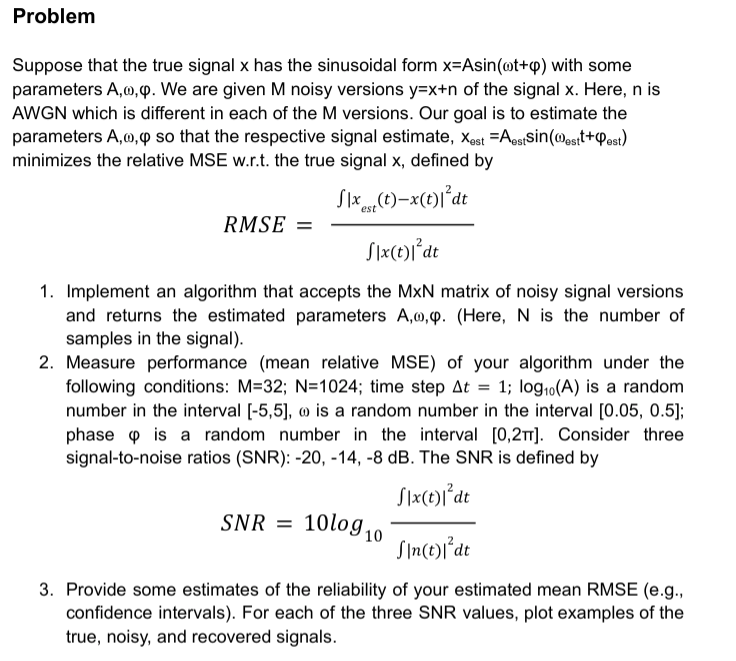

At first, let's implement signal and noise generation with given parameters. 
 

In [ ]:
%pylab inline
import torch

'''Configuarions'''

M = 32                          # Signal versions
N = 1024                        # Number of samples
step = 1                        # sample rate
A_min, A_max = 1e-5, 1e+5       # interval for amplitudes
w_min, w_max = 0.05, 0.5        # interval for frequency
phi_min,phi_max = 0, 2*math.pi  # interval for phase


random.seed(77)
torch.manual_seed(77)
np.random.seed(77)
torch.use_deterministic_algorithms(True)

Populating the interactive namespace from numpy and matplotlib


In [ ]:
def sine(x,a,w,phi):
    '''
    Returns sin signal with given params:
    @x - time samples
    @a - amplitude
    @w - frequency
    @phi - phase
    '''
    return a*torch.sin(w*x+phi)


def gen_params(isPrint = True):
    '''
    Return random parameters 
    '''
    A = np.random.uniform(low = A_min, high = A_max, size = 1)   
    w = np.random.uniform(low = w_min, high = w_max, size = 1)

    phi = np.random.uniform(low = phi_min, high = 2*np.pi, size =1)
    
    # to have phase on interval [-pi,+pi]
    if phi > math.pi: 
        phi = -(2*np.pi-phi)

    if isPrint:
        print("Amplitude: ", A[0])
        print("Frequency: ", w[0])
        print("Phase    : ", phi[0])
    return A[0],w[0],phi[0]


def random_signal(t, isPrint = True):
    A,w,phi = gen_params(isPrint)
    return sine(t,A,w,phi), A ,w , phi


def plot_signal(x):
    '''
    function for signal plotting
    '''
    plt.figure(figsize = (23,3))
    plt.plot(x)
    plt.xlim(0,N)


def plot_matrix_signal(x):
    plt.figure(figsize = (24,3))
    plt.imshow(x, cmap = 'inferno')


def get_noise(x, SNR):
    signal_power = torch.mean(torch.abs(x)**2)

    sigma = torch.sqrt(signal_power / 10**(SNR/10))
    mu = 0

    noise = torch.normal(mean = mu, std =sigma, size = x.shape)
    return noise

def experiment(isExpand = True, isPrint = True):
    t = torch.arange(0,N)
    s, A,w,phi = random_signal(t, isPrint)
    if isExpand:
        s = s.expand(size = (M,N))

    return t,s, A, w, phi

Let's look how it works.

Amplitude:  91910.9031807271
Frequency:  0.33898801996573497
Phase    :  -1.5474716995036584


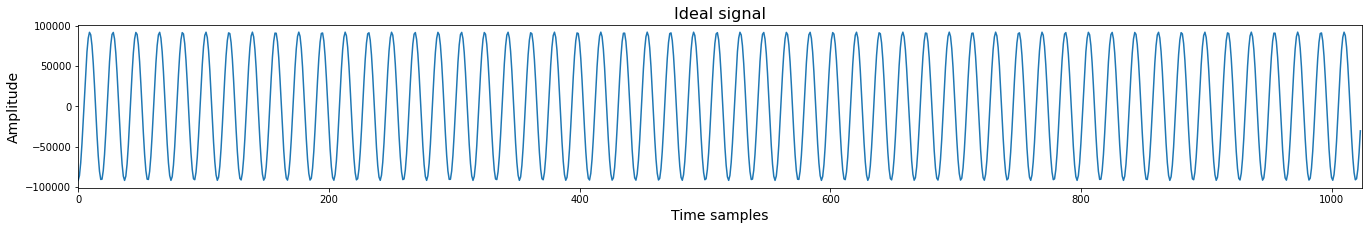

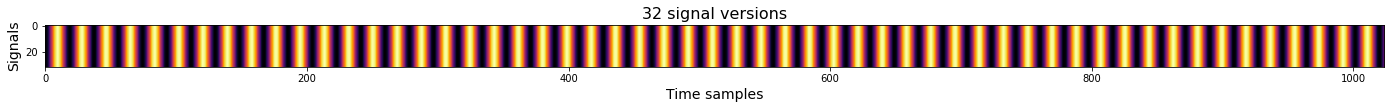

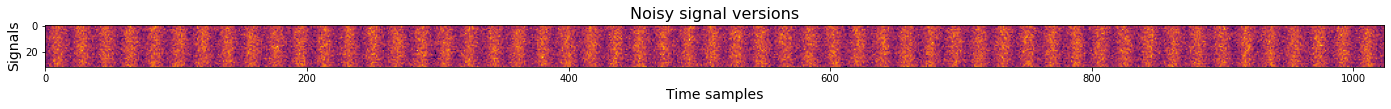

In [ ]:
# Creating and plotting an ideal signal
t,s, A_real, w_real, phi_real = experiment(False)
plot_signal(s)
plt.title('Ideal signal', fontsize = 16)
plt.xlabel('Time samples', fontsize = 14)
plt.ylabel('Amplitude', fontsize = 14)
plt.show()

# Expand dims to have several versions of the signal
s = s.expand(size = (M,N))
plot_matrix_signal(s)
plt.title(str(M)+" signal versions", fontsize = 16)
plt.xlabel('Time samples',fontsize = 14)
plt.ylabel('Signals',fontsize = 14);

# Adding a noise to ideal signal
noise = get_noise(s, -3)
sn = s+noise 
plot_matrix_signal(sn)
plt.title("Noisy signal versions", fontsize = 16)
plt.xlabel('Time samples',fontsize = 14)
plt.ylabel('Signals',fontsize = 14);

Now we can implement Loss function:

In [ ]:
def RMSE(est, true):
    return torch.sum((est-true)**2) / torch.sum(true**2) 

print('RMSE of noisy signal: ',RMSE(sn,s).item())
print('RMSE of ideal signal: ',RMSE(s,s).item())

RMSE of noisy signal:  2.0007712841033936
RMSE of ideal signal:  0.0


Now we are going to restore the ideal signal from the noisy one. Moreover, for the learning procedure, we cannot use an ideal signal, so we have to implement an Unsupervised algorithm that can return parameters of the original signal. We can use information that we have only one harmonic in all realizations with the same parameters and intervals of each parameter.


As we deal with unsupervised learning, we should understand that it is impossible to achieve 0 RMSE during optimization because we have not information about the ideal signal, and for RMSE calculating during optimization, we use noisy signal and signal with estimated parameters. It is possible to achieve an optimal solution here - the case when the estimated signal coincides with the ideal one, but in loss, we will have information about noise. As noise power depends on signal power (and on amplitude), a minimal optimized loss will also depend on signal amplitude. 


Before doing optimization, we have to take into account two important facts:



*   1) Learnable parameters (A,w, phi) have different ranges. It means that our loss function is very oblong, and for some optimization algorithms, it is a huge problem.

*   2) Moreover, in this task, we have periodical functions. It means that loss function will also have periodical behavior. It is also a massive problem for optimizers because it will be stuck in some local minima with high probability, and it is almost impossible to achieve some better minima. 


As a result, we can say that it is unreasonable to apply an optimization algorithm for this problem as it is. We have to estimate some good approximation and then optimize it. 




# First approach 
The first idea to get a good approximation of the required parameter - to use the spectrum of our signal. Let us implement the Fourier transform of the signal.

As we have sequence $x(n)$ with range of $n = 0,1,..., N-1$, so

$x(n) = x(0), x(1),...,x(N-1)$

We apply the DFT to this sequence to get N DFT coefficients:
$$
X(k) = \sum_{n=0}^{N-1}{x(n)W_N^{nk}},
$$
for $ k = 0,1,..., N-1$

We define the amplitude spectrum as
$$
A_k = \frac{1}{N}|X(k)| =\frac{1}{N}\sqrt{\Re{(X(k))}^2 + \Im{(X(k))}^2} 
$$
Furthermore, to have a one-sided amplitude spectrum, we can define it as follows:
$$
A_k = 
\begin{equation*}
\begin{cases}
\frac{1}{N}|X(0)| ,\hspace{5mm} k = 0 \\ 
\frac{2}{N}|X(k)| ,\hspace{5mm} k = 1,...N/2
\end{cases}
\end{equation*}
$$

The algorithm is as follows: 

1) We average our signal along realization dimension to make noise stable and to highlight the original signal

2) We apply DFT transform

3) We calculate the spectral density

4) Find the frequency where spectral density is maximal and amplitude of this harmonic.

Spectral density calculated as follows: 
$$
P_k = \frac{1}{N^2}|X(k)|^2 =\frac{1}{N}^2(\Re{(X(k))}^2 + \Im{(X(k))}^2)
$$
or 
$$
P_k = 
\begin{equation*}
\begin{cases}
\frac{1}{N^2}|X(0)|^2 ,\hspace{5mm} k = 0 \\ 
\frac{2}{N^2}|X(k)|^2 ,\hspace{5mm} k = 1,...N/2
\end{cases}
\end{equation*}
$$

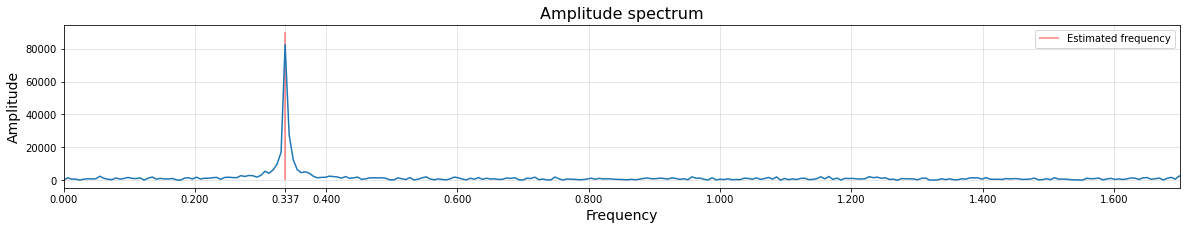

In [ ]:
# Averaging the signal
avg = torch.mean(sn,dim =0)
# spectrum
spectrum = torch.fft.fft(avg)
# spectrum density
power = (spectrum.real**2 + spectrum.imag**2)/(N**2)
# sample with max power 
sample_freq = torch.argmax(power).item()
# find its frequency
frequency = 2*math.pi*sample_freq/N


# Apply FFT shift to plot correct plot 
shifted_spectrum = torch.fft.fftshift(spectrum)
# Amplitude spectrum
am_spec = 2/N * torch.abs(shifted_spectrum)
# get frequency axis
freq_axis,_ = torch.sort(torch.fft.fftfreq(N,1/(np.pi*2)))

# plotting
plt.figure(figsize=(20,3))
plt.plot(freq_axis.numpy(), am_spec.numpy())
plt.title("Amplitude spectrum", fontsize = 16)
plt.xlabel("Frequency", fontsize = 14)
plt.ylabel("Amplitude", fontsize = 14)
min_tick,max_tick = np.min(freq_axis.numpy()), np.max(freq_axis.numpy())  
ticks = np.arange(np.round(min_tick,0), max_tick, 0.2)
plt.xticks(list(ticks) + [frequency])
# Plot only positive frequencies
plt.xlim(0, 1.7)
plt.vlines(frequency, ymin=-2, ymax =90000, alpha = 0.5, color = 'r', label = 'Estimated frequency')
plt.legend()
plt.grid(alpha =0.4)
plt.show()

In [ ]:
print('Absolute Difference between real and est: ', abs(frequency-w_real))
print('Relative Difference between real and est: ', abs(frequency-w_real)/w_real*100,'%')

Difference between real and est:  0.0015122466308938876


And result is very good even with extremely low SNR values. For example for -30 dB we stil can find frequency of ideal signal

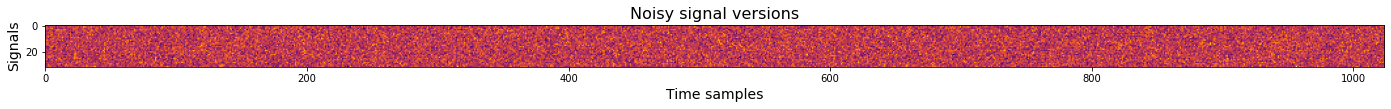

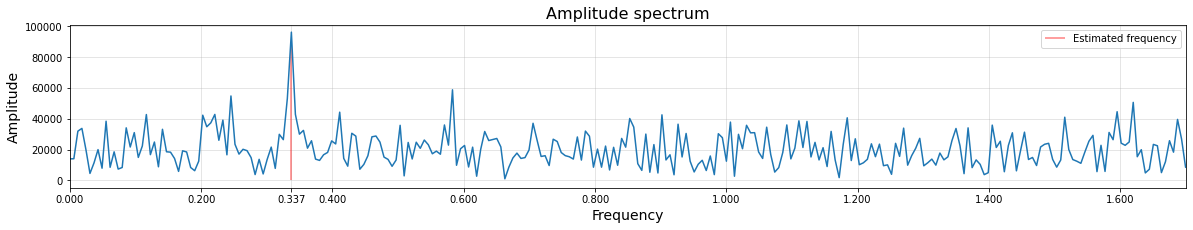

In [ ]:
noise_ = get_noise(s, -30)
sn_ = s+noise_ 

plot_matrix_signal(sn_)
plt.title("Noisy signal versions", fontsize = 16)
plt.xlabel('Time samples',fontsize = 14)
plt.ylabel('Signals',fontsize = 14);


avg = torch.mean(sn_,dim =0)
spectrum = torch.fft.fft(avg)
power = (spectrum.real**2 + spectrum.imag**2)/(N**2)
sample_freq = torch.argmax(power).item()

frequency = 2*math.pi*sample_freq/N

shifted_spectrum = torch.fft.fftshift(spectrum)
am_spec = 2/N * torch.abs(shifted_spectrum)
freq_axis,_ = torch.sort(torch.fft.fftfreq(N,1/(np.pi*2)))


plt.figure(figsize=(20,3))
plt.plot(freq_axis.numpy(), am_spec.numpy())
plt.title("Amplitude spectrum", fontsize = 16)
plt.xlabel("Frequency", fontsize = 14)
plt.ylabel("Amplitude", fontsize = 14)
min_tick,max_tick = np.min(freq_axis.numpy()), np.max(freq_axis.numpy())  
ticks = np.arange(np.round(min_tick,0), max_tick, 0.2)
plt.xticks(list(ticks) + [frequency])
plt.xlim(0, 1.7)
plt.vlines(frequency, ymin=-2, ymax =90000, alpha = 0.5, color = 'r', label = 'Estimated frequency')
plt.legend()
plt.grid(alpha =0.4)
plt.show()


In [ ]:
print('Absolute Difference between real and est: ', abs(frequency-w_real))
print('Relative Difference between real and est: ', abs(frequency-w_real)/w_real*100,'%')

Difference between real and est:  0.0015122466308938876


However, it is pretty challenging to get such a good result with extraction information about amplitude because of spectral leakage - we have not ideal delta function for sin spectrum, but some crest. According to the conditions, we can only use a sample rate equals to 1; therefore, we cannot avoid this effect. Also, we cannot calculate the energy of neighbor parts of this spectrum because they have pretty low energy. Therefore they are corrupted by noise so that the estimation will be inaccurate. 

However, we can reduce the impact of this effect a bit by aligning phases of the signal boundaries so as not to have a rapid gap between the beginning and end of the signal. We can calculate the signal period using estimated frequency and cut some end samples to have a signal with an integer number of periods. However, estimation of frequency not ideal, and the estimated period is also not ideal because of the discrete nature of our data. As a result, amplitude estimation becomes a bit better but still far from the required result. 

So we can implement function that do estimation of the frequency and amplitude, using signal spectrum.

In [ ]:
def fft_estimate(signal):
    avg = torch.mean(signal, dim = 0)

    spectrum = torch.fft.fft(avg)
    power_spec = (spectrum.real**2 + spectrum.imag**2)/(N**2)

    sample_freq = torch.argmax(power_spec).item()
    frequency = 2*math.pi*sample_freq/N

    # period calculating
    period = 1/frequency*math.pi*2
    # integer period
    int_period = int(np.ceil(period))
    int_samples = int(np.ceil(period*(N//int_period)))
    # cut last samples
    spectrum_cut = spectrum[:int_samples]

    #calculate amplitude
    amplitudes = 2/int_samples * torch.abs(spectrum_cut)
    max_am = torch.max(amplitudes)

    return frequency, max_am.item()

In [ ]:
est_freq, est_am  = fft_estimate(sn)
print('Amplitude error:' , abs(A_real - est_am)/A_real * 100, '%')
print('Frequency error:', abs(w_real - est_freq)/w_real * 100, '%' )

Amplitude error: 6.993955717731466 %
Frequency error: 0.4461062166877597 %


Also I plotted Angle spectum and it looks extremely noisy even with high SNR valus. Seems it's impossible to restore correct information about phase from it. So I decided to use another method to estimate phase.

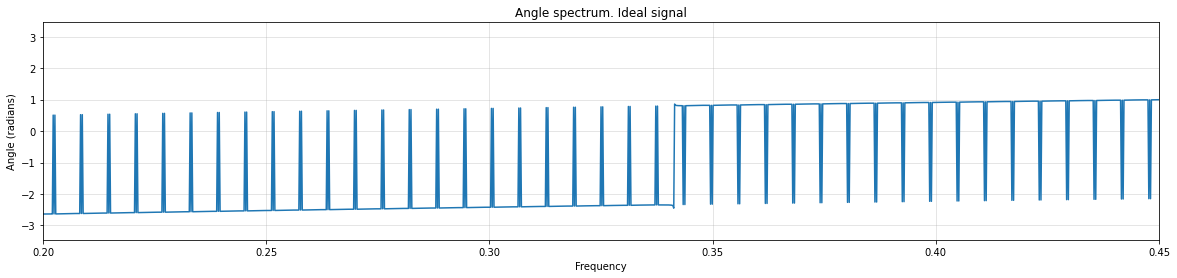

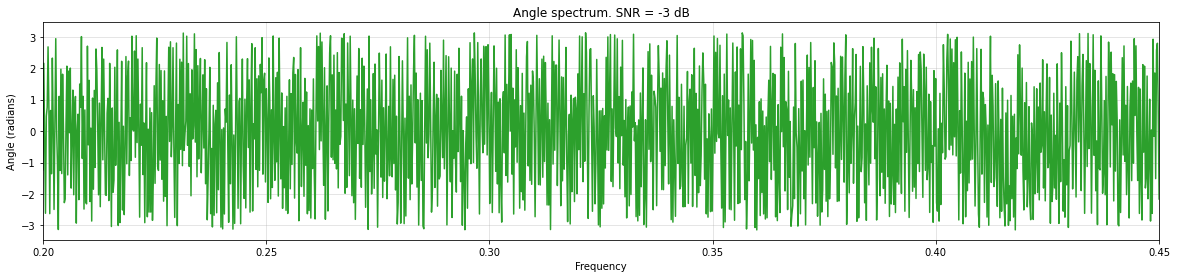

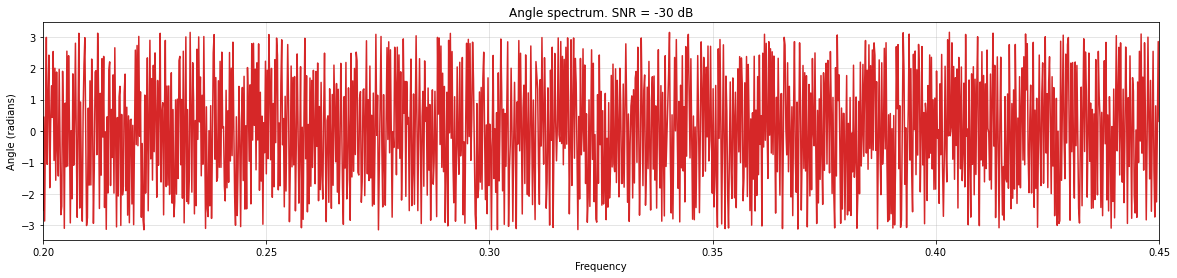

In [ ]:
plt.figure(figsize(20,4))
plt.angle_spectrum(s.flatten(), Fs = 2*math.pi, label = 'Ideal')
plt.title('Angle spectrum. Ideal signal')
plt.grid(alpha = 0.4)
plt.xlim(0.2,0.45);

plt.figure(figsize(20,4))
plt.angle_spectrum(sn.flatten(), Fs = 2*math.pi, label = 'SNR = -3', color = 'tab:green')
plt.title('Angle spectrum. SNR = -3 dB')
plt.grid(alpha = 0.4)
plt.xlim(0.2,0.45);

plt.figure(figsize(20,4))
plt.angle_spectrum(sn_.flatten(), Fs = 2*math.pi , label = 'SNR = -30', color = 'tab:red')
plt.title('Angle spectrum. SNR = -30 dB')
plt.grid(alpha = 0.4)
plt.xlim(0.2,0.45);

Then I decided to change the approximation and use a method that would give fewer problems with phase.
We can use the fact that we know the form of our signal and construct a method that does crosscorrelation with noisy signal and estimated. If the estimated signal coincides with an ideal signal that is under the noise - we detect it. 

At first, I averaged the signal matrix along M dimension (signal realizations). It allows to highlight the ideal signal and make the noise stable.

Then I fixed 2 of 3 parameters of sin function, we assumed that we already know them. After that, I decided to convolve all possible versions. To make the process fast, I used the torch library, which can use GPU, and created special kernels for convolution that variates the signal parameters. 


In [ ]:
def create_batch(param, min_v, max_v, batch_size, A = None, phi = None, w = None):
    '''
    Function for kernel creation
    @param - str :{'w','A','phi'}. Which type of kernel we want to create
    @min_v - min possible value of @param
    @max_v - max possible value of @param
    @batch_size - Kernel resolution
    other - singal params
    '''
    t = torch.arange(0,1024)
    
    batch = torch.tensor([])
    scale = []

    #Frequency kernel
    if param == 'w':
        for w in torch.linspace(min_v, max_v, batch_size):
            if len(batch) == 0:
                batch = sine(t,A,w,phi)
                batch = batch.unsqueeze(0).unsqueeze(0)
                assert len(batch.size()) == 3, "Wrong batch size"
            else:
                batch = torch.cat((batch,sine(t,A,w,phi).unsqueeze(0).unsqueeze(0)), dim = 0)
            
            scale.append(w)
    
    # Amplitude kernel
    elif param == 'A':
        for A in torch.linspace(min_v, max_v, batch_size):
            if len(batch) == 0:
                batch = sine(t,A,w,phi)
                batch = batch.unsqueeze(0).unsqueeze(0)
                assert len(batch.size()) == 3, "Wrong batch size"
            else:
                batch = torch.cat((batch,sine(t,A,w,phi).unsqueeze(0).unsqueeze(0)), dim = 0)
            
            scale.append(A)

    # Phase kernel
    elif param == 'phi':
        for phi in torch.linspace(min_v, max_v, batch_size):
            if len(batch) == 0:
                batch = sine(t,A,w,phi)
                batch = batch.unsqueeze(0).unsqueeze(0)
                assert len(batch.size()) == 3, "Wrong batch size"
            else:
                batch = torch.cat((batch,sine(t,A,w,phi).unsqueeze(0).unsqueeze(0)), dim = 0)
            
            scale.append(phi)

    return batch, np.array(scale)


**Frequency kernel**

In [ ]:
s = torch.mean(s, dim=0).unsqueeze(0).unsqueeze(0)
noise = torch.mean(noise, dim=0).unsqueeze(0).unsqueeze(0)
sn = torch.mean(sn, dim=0).unsqueeze(0).unsqueeze(0)
sn_ = torch.mean(sn_, dim=0).unsqueeze(0).unsqueeze(0)

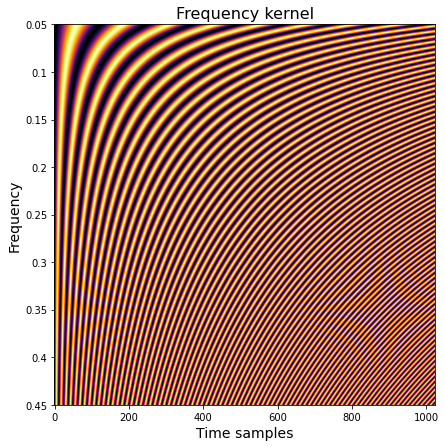

In [ ]:
# create phase kernel
freq_kernel, freq_scale = create_batch(param = 'w', min_v = 0.05, max_v= 0.5, batch_size= 1024, A = A_real ,phi =   phi_real)
#plot kernel
plt.figure(figsize = (7,7))
plt.title("Frequency kernel", fontsize = 16)
plt.ylabel("Frequency", fontsize = 14)
plt.xlabel("Time samples", fontsize = 14)

freq_scale = np.array(freq_scale)
min_tick,max_tick = np.min(freq_scale), np.max(freq_scale)
ticks = np.round(np.arange(min_tick, max_tick, 0.05),3).tolist()
plt.yticks(np.linspace(0,1023, 9))
plt.gca().set_yticklabels(ticks)
plt.imshow(freq_kernel[:,0,:], cmap = 'inferno');

In [ ]:
#kernel convolution
conv_freq  = torch.conv1d(sn, freq_kernel)

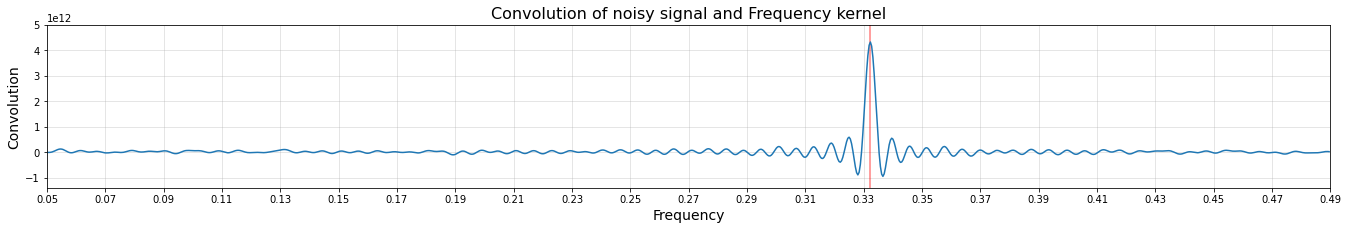

Max frequency:  0.339


In [ ]:
result = conv_freq[0].flatten()
plot_signal(result)
plt.title('Convolution of noisy signal and Frequency kernel', fontsize = 16)
plt.xlabel('Frequency', fontsize = 14)
plt.ylabel('Convolution', fontsize = 14)

arg = torch.argmax(torch.abs(result.flatten()))
plt.vlines(arg, -3e+12, 7e+12, alpha =0.5 ,color = 'r')
plt.ylim(-1.4e+12, 5e+12);

ticks = np.round(np.arange(min_tick, max_tick, 0.02),3).tolist()
plt.xticks(np.linspace(0,N,len(ticks)))
plt.gca().set_xticklabels(ticks)

plt.grid(alpha = 0.4)
plt.show()
print("Max frequency: ", np.round(freq_scale[arg],5))

In [ ]:
print('Frequency error:', abs(w_real - freq_scale[arg])/w_real * 100, '%' )

Frequency error: 0.00440048375234447 %


Seems that the result is better as it was achieved with FFT. To make prediction even more accurate, we can increase kernel size (add more frequencies), or after the first convolution we can apply the second convolution with a kernel that has high resolution in the area where the desired frequency is located. However, as we are going to use optimization after this approximation, we can use the current result. 

Also, this approach showed good result with low SNR case (-30 dB)

In [ ]:
conv_freq  = torch.conv1d(sn_, freq_kernel)

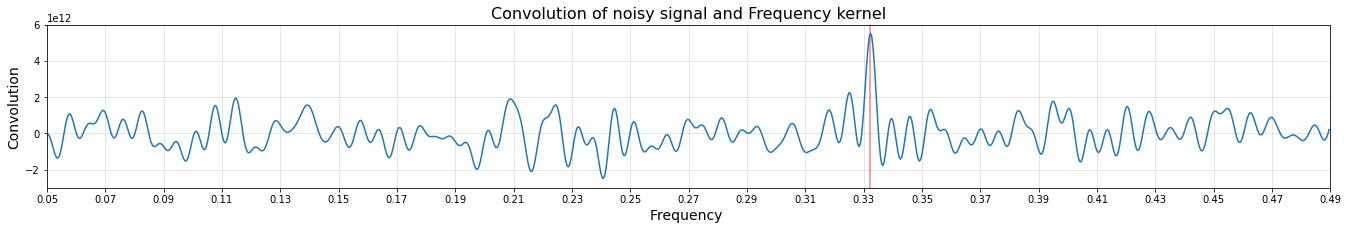

Max frequency:  0.339


In [ ]:
result = conv_freq[0].flatten()
plot_signal(result)
plt.title('Convolution of noisy signal and Frequency kernel', fontsize = 16)
plt.xlabel('Frequency ', fontsize = 14)
plt.ylabel('Convolution', fontsize = 14)

arg = torch.argmax(torch.abs(result.flatten()))
plt.vlines(arg, -3e+12, 7e+12, alpha =0.5 ,color = 'r')
plt.ylim(-3e+12, 6e+12);

ticks = np.round(np.arange(min_tick, max_tick, 0.02),3).tolist()
plt.xticks(np.linspace(0,N,len(ticks)))
plt.gca().set_xticklabels(ticks)

plt.grid(alpha = 0.4)
plt.show()
print("Max frequency: ", np.round(freq_scale[arg],5))

In [ ]:
print('Frequency error:', abs(w_real - freq_scale[arg])/w_real * 100, '%' )

Frequency error: 0.00440048375234447 %


This approach demonstrated better results than the FFT approach. However, in my estimator, I decided to use FFT because the frequency kernel requires phase information. If we use a random phase for the kernel, we can achieve much worse results. For example, we can look at how the result changes when the difference between real and estimated phase in the kernel is equal to $\pi/2$

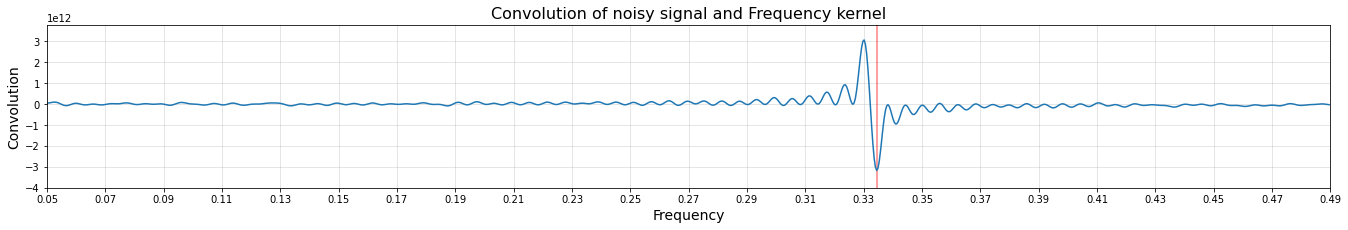

Max frequency:  0.3412


In [ ]:
freq_kernel_, freq_scale_ = create_batch(param = 'w', min_v = 0.05, max_v= 0.5, batch_size= 1024, A = A_real ,phi =   phi_real+np.pi/2)
conv_freq_  = torch.conv1d(sn, freq_kernel_)
result_ = conv_freq_[0].flatten()
plot_signal(result_)
plt.title('Convolution of noisy signal and Frequency kernel', fontsize = 16)
plt.xlabel('Frequency', fontsize = 14)
plt.ylabel('Convolution', fontsize = 14)

arg = torch.argmax(torch.abs(result_.flatten()))
plt.vlines(arg, -5e+12, 7e+12, alpha =0.5 ,color = 'r')
plt.ylim(-4.0e+12, 3.8e+12);

min_tick,max_tick = np.min(freq_scale_), np.max(freq_scale_)
ticks = np.round(np.arange(min_tick, max_tick, 0.02),3).tolist()
plt.xticks(np.linspace(0,N,len(ticks)))
plt.gca().set_xticklabels(ticks)

plt.grid(alpha = 0.4)
plt.show()
print("Max frequency: ", np.round(freq_scale_[arg],5))

In [ ]:
print('Frequency error:', abs(w_real - freq_scale[arg])/w_real * 100, '%' )

Frequency error: 0.653217333514242 %


**Phase kernel**

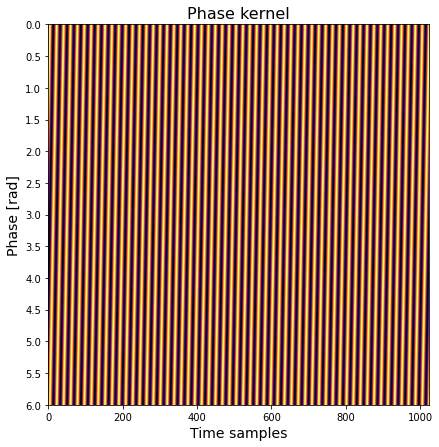

In [ ]:
phase_kernel, phase_scale = create_batch(param = 'phi', min_v = 0 , max_v= 2*math.pi, batch_size= 1024, A = A_real , w = w_real)
plt.figure(figsize = (7,7))
plt.title("Phase kernel", fontsize = 16)
plt.ylabel("Phase [rad]", fontsize = 14)
plt.xlabel("Time samples", fontsize = 14)

phase_scale = np.array(phase_scale)
min_tick,max_tick = np.min(phase_scale), np.max(phase_scale)
ticks = np.round(np.arange(min_tick, max_tick, 0.5),3).tolist()

plt.yticks(np.linspace(0,1023, len(ticks)))
plt.gca().set_yticklabels(ticks)
plt.imshow(phase_kernel[:,0,:], cmap = 'inferno');

In [ ]:
conv_phase = torch.conv1d(sn, phase_kernel)

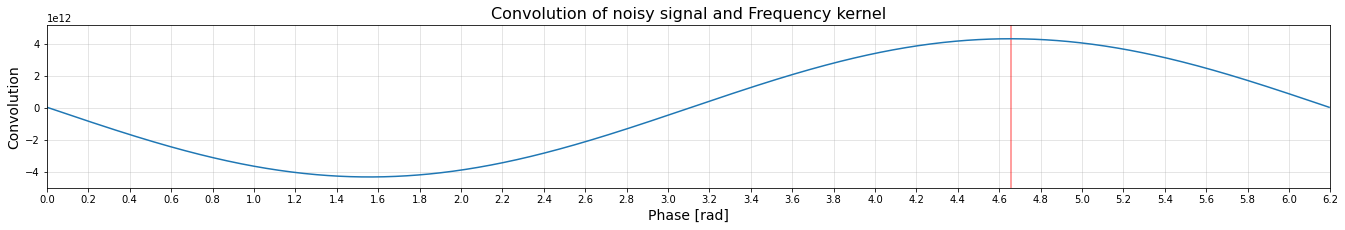

Max Phase:  4.72314


In [ ]:
result = conv_phase[0].flatten()
plot_signal(result)
plt.title('Convolution of noisy signal and Frequency kernel', fontsize = 16)
plt.xlabel('Phase [rad]', fontsize = 14)
plt.ylabel('Convolution', fontsize = 14)

arg = torch.argmax(result.flatten())
plt.vlines(arg, -6e+12, 6e+12, alpha =0.5 ,color = 'r')
plt.ylim(-5e+12, 5.2e+12);

ticks = np.round(np.arange(min_tick, max_tick, 0.2),3).tolist()
plt.xticks(np.linspace(0,N,len(ticks)))
plt.gca().set_xticklabels(ticks)

plt.grid(alpha = 0.4)
plt.show()
print("Max Phase: ", np.round(phase_scale[arg],5))

In [ ]:
print('Phase error:', abs(phi_real - phase_scale[arg])/phi_real * 100, '%' )

Phase error: 0.2655513653899842 %


And again we have almost perfect result. For low SNR realisations sometimes method gives bad results, so it is not very stable.

In [ ]:
conv_phase = torch.conv1d(sn_, phase_kernel)

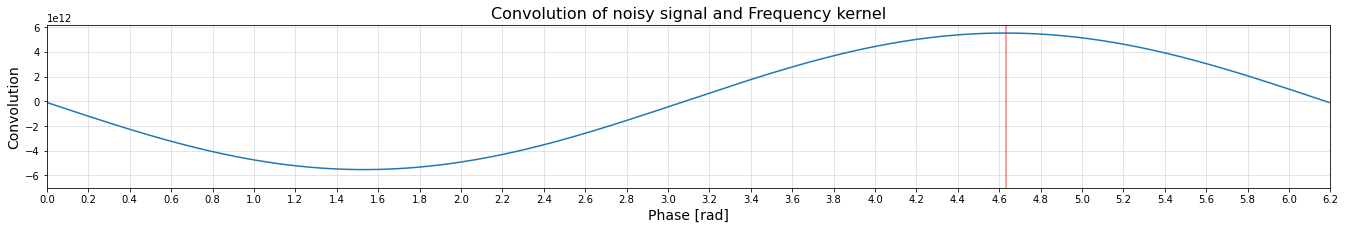

Max Phase:  4.69857


In [ ]:
result = conv_phase[0].flatten()
plot_signal(result)
plt.title('Convolution of noisy signal and Frequency kernel', fontsize = 16)
plt.xlabel('Phase [rad]', fontsize = 14)
plt.ylabel('Convolution', fontsize = 14)

arg = torch.argmax(result.flatten())
plt.vlines(arg, -7e+12, 7e+12, alpha =0.5 ,color = 'r')
plt.ylim(-7e+12, 6.2e+12);

ticks = np.round(np.arange(min_tick, max_tick, 0.2),3).tolist()
plt.xticks(np.linspace(0,N,len(ticks)))
plt.gca().set_xticklabels(ticks)

plt.grid(alpha = 0.4)
plt.show()
print("Max Phase: ", np.round(phase_scale[arg],5))

In [ ]:
print('Phase error:', abs(phi_real - phase_scale[arg])/phi_real * 100, '%' )

Phase error: 0.7843344451412215 %


**Amplitude kernel**

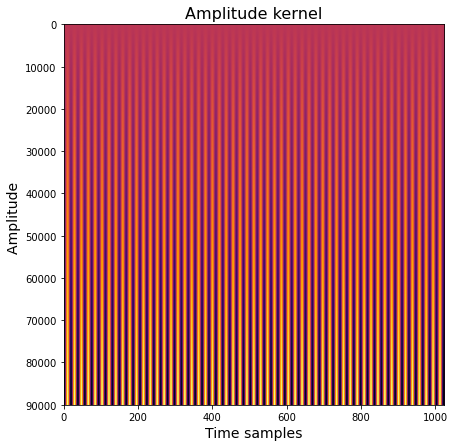

In [ ]:
am_kernel, am_scale = create_batch(param = 'A', min_v = 1e-5 , max_v= 1e+5, batch_size= 1024, phi = phi_real , w = w_real)
plt.figure(figsize = (7,7))
plt.title("Amplitude kernel", fontsize = 16)
plt.ylabel("Amplitude ", fontsize = 14)
plt.xlabel("Time samples", fontsize = 14)

am_scale = np.array(am_scale)
min_tick,max_tick = np.min(am_scale), np.max(am_scale)
ticks = np.round(np.arange(min_tick, max_tick, 1e+4)). astype(int).tolist()

plt.yticks(np.linspace(0,1023, len(ticks)))
plt.gca().set_yticklabels(ticks)
plt.imshow(am_kernel[:,0,:], cmap = 'inferno');

In [ ]:
conv_am = torch.conv1d(sn, am_kernel)

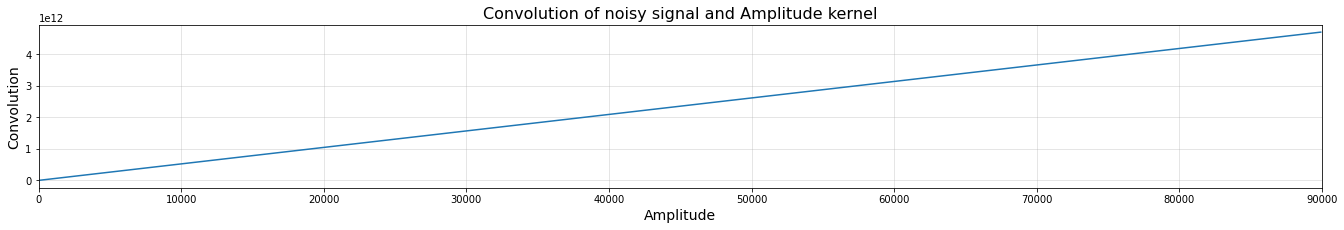

In [ ]:
result = conv_am[0].flatten()
plot_signal(result)
plt.title('Convolution of noisy signal and Amplitude kernel', fontsize = 16)
plt.xlabel('Amplitude', fontsize = 14)
plt.ylabel('Convolution', fontsize = 14)

ticks = np.round(np.arange(min_tick, max_tick, 1e+4),3).astype(int).tolist()
plt.xticks(np.linspace(0,N,len(ticks)))
plt.gca().set_xticklabels(ticks)

plt.grid(alpha = 0.4)
plt.show()


Unexpectedly we got this result, and it is evident because the more amplitude we increase, the more correlation will be. But correlation not only with our real signal but also with the noise.

I tried to fix this problem. While we tune the amplitude, we want that correlation to increase and, after some moment, decrease because tuned amplitude becomes higher than the amplitude of the ideal signal. Therefore it would be reasonable to deal with some difference, not with absolute value. 
For example, let us use the difference between our noisy signal and kernel. Then we will get a new kernel - difference kernel. Versions of signal in this kernel contain information about noise and ideal signal residues. However, in realization, which coincides with the ideal signal, we will have only noise! Therefore we can convolve this difference kernel with kernel, and we will find optimal amplitude estimation where we have no correlation.   

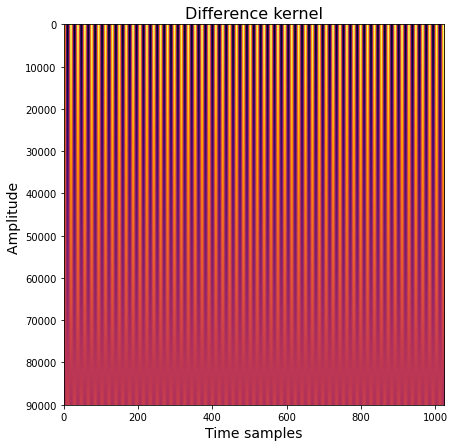

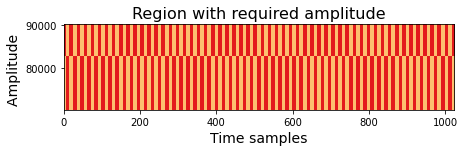

In [ ]:
dif_kernel  = am_kernel - s

plt.figure(figsize = (7,7))
plt.title("Difference kernel", fontsize = 16)
plt.ylabel("Amplitude ", fontsize = 14)
plt.xlabel("Time samples", fontsize = 14)

am_scale = np.array(am_scale)
min_tick,max_tick = np.min(am_scale), np.max(am_scale)
ticks = np.round(np.arange(min_tick, max_tick, 1e+4)). astype(int).tolist()

plt.yticks(np.linspace(0,1023, len(ticks)))
plt.gca().set_yticklabels(ticks)
plt.imshow(dif_kernel[:,0,:], cmap = 'inferno');
plt.show()


plt.figure(figsize = (7,5))
plt.title("Region with required amplitude", fontsize = 16)
plt.ylabel("Amplitude ", fontsize = 14)
plt.yticks(np.linspace(0,1023, len(ticks)))
plt.gca().set_yticklabels(ticks)
plt.imshow(dif_kernel[:,0,:], cmap = 'Paired');
plt.xlabel("Time samples", fontsize = 14)
plt.ylim(800,1024 );

On the picture, we can see the region where the periodical signal disappears. But it was the case with the ideal signal. When I tried this approach with a noisy signal, it failed. 

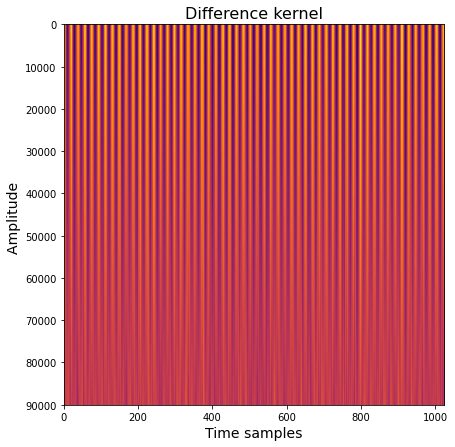

In [ ]:
dif_kernel  = am_kernel - sn

plt.figure(figsize = (7,7))
plt.title("Difference kernel", fontsize = 16)
plt.ylabel("Amplitude ", fontsize = 14)
plt.xlabel("Time samples", fontsize = 14)

am_scale = np.array(am_scale)
min_tick,max_tick = np.min(am_scale), np.max(am_scale)
ticks = np.round(np.arange(min_tick, max_tick, 1e+4)). astype(int).tolist()

plt.yticks(np.linspace(0,1023, len(ticks)))
plt.gca().set_yticklabels(ticks)
plt.imshow(dif_kernel[:,0,:], cmap = 'inferno');

As a result I made an Estimator that uses FFT transform for frequency and amplitude estimation. And phase kernel for phase estimation. 
However when I tried to evaluate the solution, it turned out that kernel calculating is quite long operation. I think it is possible to make it faster, but I decided to try another method in order to save time.

In [ ]:
class Estimator():
    def __init__(self):
        self.phase_kernel = None
        pass
    
    def __fft_estimate(self, signal):
        '''
        FFT frequency and amplitude estimation
        '''

        avg = torch.mean(signal, dim = 0)

        spectrum = torch.fft.fft(avg)
        power_spec = (spectrum.real**2 + spectrum.imag**2)/(N**2)

        sample_freq = torch.argmax(power_spec).item()
        frequency = 2*math.pi*sample_freq/N

        period = 1/frequency*math.pi*2
        int_period = int(np.ceil(period))
        
        int_samples = int(np.ceil(period*(N//int_period)))

        spectrum_cut = spectrum[:int_samples]

        amplitudes = 2/int_samples * torch.abs(spectrum_cut)
        max_am = torch.max(amplitudes)

        self.est_freq = frequency
        self.est_am = max_am

        return frequency, max_am.item()
    
    def __create_phase_kernel(self):
        if self.phase_kernel == None:
            self.phase_kernel, self.phase_scale = create_batch(param = 'phi',
                                                                min_v = 0,
                                                                max_v= 2*math.pi,
                                                                batch_size= 4000,
                                                                A = self.est_am,
                                                                w = self.est_freq)
            
    def __phase_estimation(self,signal):
        '''
        phase estimation with kernel
        '''
        conv_phase = torch.conv1d(signal, self.phase_kernel)
        res = conv_phase[0].flatten()
        arg = torch.argmax(res)
        self.est_phase = self.phase_scale[arg]

    
    def estimate(self,signal):
        '''
        method that does estimation
        '''
        signal = torch.mean(signal, dim=0).unsqueeze(0).unsqueeze(0)
        self.__fft_estimate(signal)
        self.__create_phase_kernel()
        self.__phase_estimation(signal)

        return self.est_freq, self.est_am.item(), self.est_phase


I decided to use Heterodine signal to estimate phase. 
The method is follows:

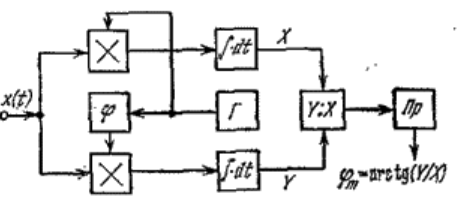

1) We generate an auxiliary signal with estimated frequency:

 $S_1 = A_1*\cos(w_{est}t+0)$.

2) We create it's copy with phase shift of $\pi/2$: 

$S_2 = A_1*\cos(w_{est}t+\pi/2)$

3) We independently multiply our noisy signal $S_n$ with $S_1$ and $S_2$

4) Then initial phase can be found as follows:
$$
\phi = \arctan(\frac{\int^T_0{S_n(t)*S_2(t)}}{\int^T_0{S_n(t)*S_1(t)}})
$$

As a result the estimator was reconstructed.

In [ ]:
class Estimator():
    def __init__(self):
        self.phase_kernel = None
        pass
    
    def __fft_estimate(self, signal):
        spectrum = torch.fft.fft(signal)
        power_spec = (spectrum.real**2 + spectrum.imag**2)/(N**2)

        sample_freq = torch.argmax(power_spec).item()
        frequency = 2*math.pi*sample_freq/N

        period = 1/frequency*math.pi*2
        int_period = int(np.ceil(period))
        
        int_samples = int(np.ceil(period*(N//int_period)))

        spectrum_cut = spectrum[:int_samples]

        amplitudes = 2/int_samples * torch.abs(spectrum_cut)
        max_am = torch.max(amplitudes)

        self.est_freq = frequency
        self.est_am = max_am

        return frequency, max_am.item()
    

    def __phase_estimation(self,signal):
        heterodine = sine(t, self.est_am*1.8, self.est_freq, 0)
        heterodine_shifted = sine(t, self.est_am*1.8,self.est_freq, math.pi/2)
        Y = torch.sum(signal*heterodine_shifted)
        X = torch.sum(signal*heterodine_shifted)
        self.est_phase = torch.atan2(Y,X)
    
    def estimate(self,signal):
        signal = torch.mean(signal, dim=0)
        self.__fft_estimate(signal)
        self.__phase_estimation(signal)

        return self.est_freq, self.est_am.item(), self.est_phase


In [ ]:
estimator = Estimator()

Let's check how Simple estimator works on defferent SNR values

In [ ]:
dA_ = np.empty((10000,7))
dw_ = np.empty((10000,7))
dphi_ = np.empty((10000,7))
drmse_ = np.empty((10000,7))

for id,snr in enumerate(snr_range):    
    for repeat in tqdm(range(10000)):
        tt, st, At, wt, pt = experiment(isExpand=True,isPrint = False)
        nt = get_noise(st, snr)
        stn = st + nt
        est_w, est_A, est_phi = estimator.estimate(stn)

        dA_[repeat, id] = abs(At-est_A)/At*100
        dw_[repeat, id] = abs(wt-est_w)/wt*100
        dphi_[repeat, id] = abs(est_phi - pt)
        drmse_[repeat, id] = RMSE(sine(x=tt, a=est_A, w= est_w, phi=est_phi), st).item()


100%|██████████| 10000/10000 [00:10<00:00, 937.52it/s]


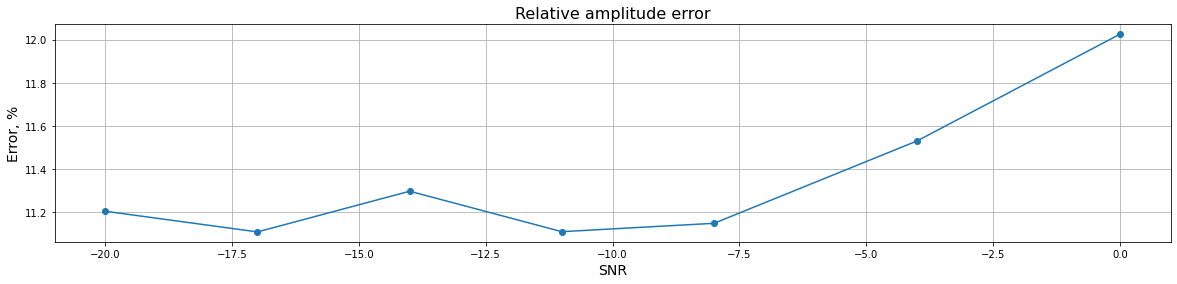

In [ ]:
plt.title("Relative amplitude error", fontsize = 16)
plt.xlabel("SNR", fontsize= 14)
plt.ylabel("Error, %", fontsize= 14)
plt.plot([-20,-17,-14,-11,-8,-4,0] ,np.mean(dA_, axis = 0), 'o-')
plt.grid()

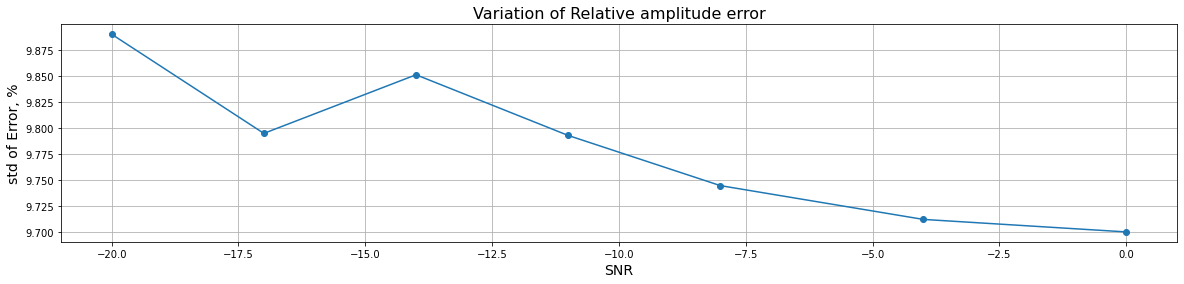

In [ ]:
plt.title("Variation of Relative amplitude error", fontsize = 16)
plt.xlabel("SNR", fontsize= 14)
plt.ylabel("std of Error, %", fontsize= 14)
plt.plot([-20,-17,-14,-11,-8,-4,0] ,(np.std(dA_, axis = 0)), 'o-')
plt.grid()

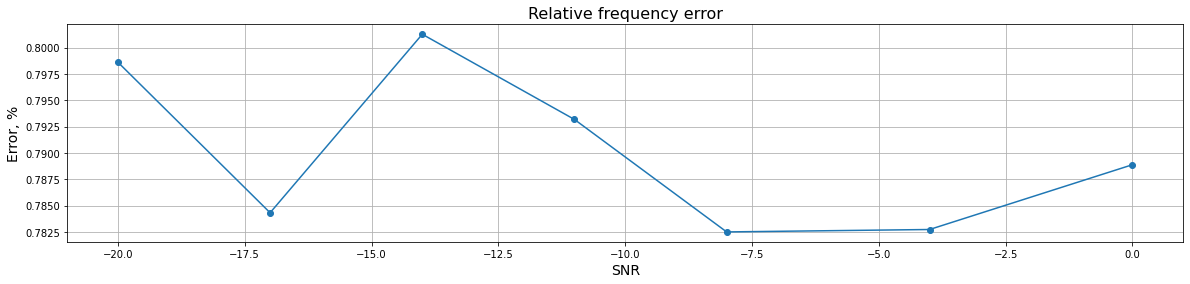

In [ ]:
plt.title("Relative frequency error", fontsize = 16)
plt.xlabel("SNR", fontsize= 14)
plt.ylabel("Error, %", fontsize= 14)
plt.plot([-20,-17,-14,-11,-8,-4,0] ,(np.mean(dw_, axis = 0)), 'o-')
plt.grid()

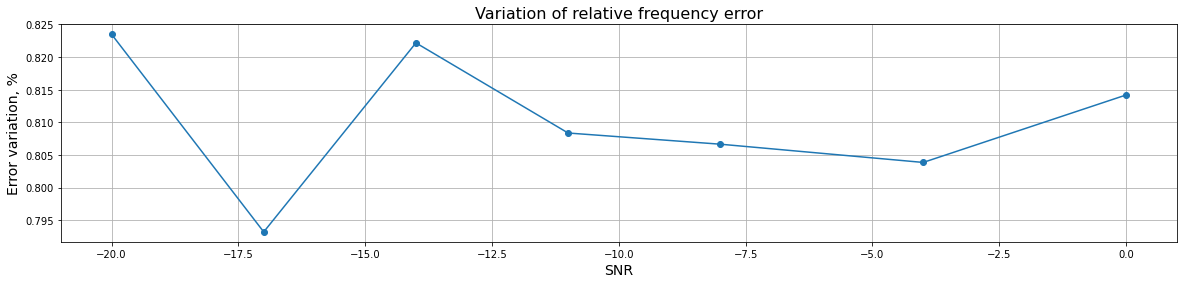

In [ ]:
plt.title("Variation of relative frequency error", fontsize = 16)
plt.xlabel("SNR", fontsize= 14)
plt.ylabel("Error variation, %", fontsize= 14)
plt.plot([-20,-17,-14,-11,-8,-4,0] ,(np.std(dw_, axis = 0)), 'o-')
plt.grid()

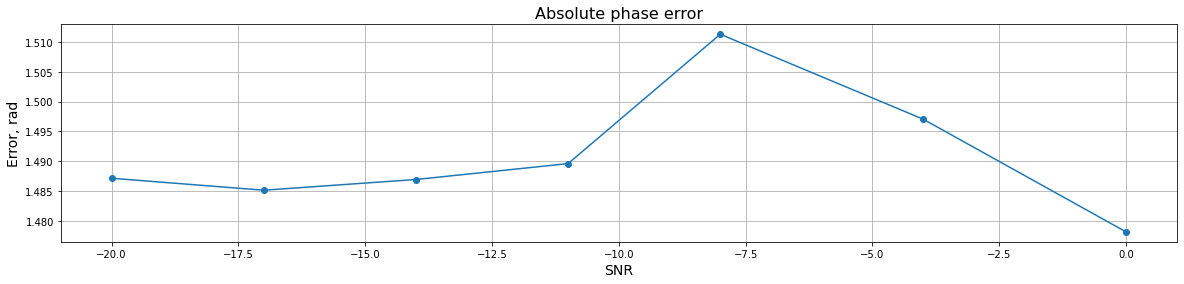

In [ ]:
plt.title("Absolute phase error", fontsize = 16)
plt.xlabel("SNR", fontsize= 14)
plt.ylabel("Error, rad", fontsize= 14)
plt.plot([-20,-17,-14,-11,-8,-4,0] ,(np.mean(dphi_, axis = 0)), 'o-')
plt.grid()

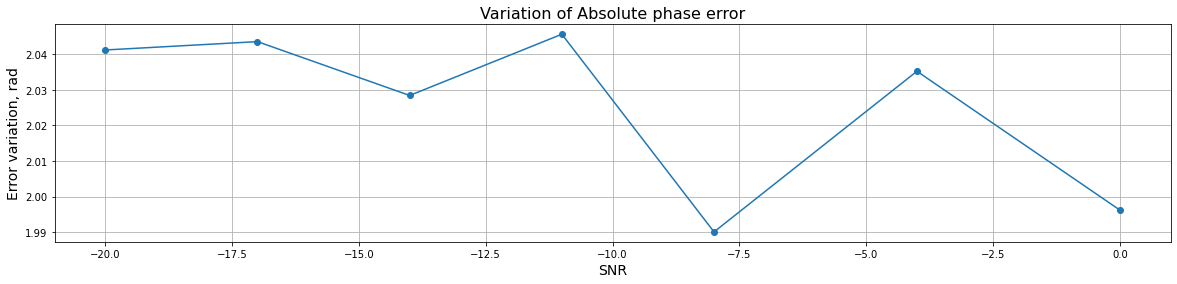

In [ ]:
plt.title("Variation of Absolute phase error", fontsize = 16)
plt.xlabel("SNR", fontsize= 14)
plt.ylabel("Error variation, rad", fontsize= 14)
plt.plot([-20,-17,-14,-11,-8,-4,0] ,(np.std(dphi, axis = 0)), 'o-')
plt.grid()

Finaly we applied optimization method Nelder-Mead to achieve local minima

In [ ]:
import scipy 
from scipy import optimize
class ML_Estimator():
    def __init__(self):
        pass
    
    def __fft_estimate(self, signal):

        spectrum = torch.fft.fft(signal)
        power_spec = (spectrum.real**2 + spectrum.imag**2)/(N**2)

        sample_freq = torch.argmax(power_spec).item()
        frequency = 2*math.pi*sample_freq/N

        period = 1/frequency*math.pi*2
        int_period = int(np.ceil(period))
        
        int_samples = int(np.ceil(period*(N//int_period)))

        spectrum_cut = spectrum[:int_samples]

        amplitudes = 2/int_samples * torch.abs(spectrum_cut)
        max_am = torch.max(amplitudes)

        self.est_freq = frequency
        self.est_am = max_am

        return frequency, max_am.item()
    

    def __phase_estimation(self,signal):
        heterodine = sine(t, self.est_am*1.8, self.est_freq, 0)
        heterodine_shifted = sine(t, self.est_am*1.8,self.est_freq, math.pi/2)
        Y = torch.sum(signal*heterodine_shifted)
        X = torch.sum(signal*heterodine_shifted)
        self.est_phase = torch.atan2(Y,X)
    
    def estimate(self,signal):
        signal = torch.mean(signal, dim=0)
        self.__fft_estimate(signal)
        self.__phase_estimation(signal)
        self.__optimize(signal)

        return self.est_freq, self.est_am, self.est_phase

    def __optimize(self, signal):
        '''
        Optimization algorithm
        '''

        t = np.arange(0,N)
        signal = signal.numpy()

        def rmse(est, true):
            return np.sum((est-true)**2) / np.sum(true**2)
        
        def function(x):
            return rmse(x[0]*np.sin(x[1]*t + x[2]), signal)
        
        res = scipy.optimize.minimize(function, method = 'Nelder-Mead', x0 = [self.est_am ,self.est_freq, self.est_phase])
        self.est_am = res.x[0]
        self.est_freq = res.x[1]
        self.est_phase = res.x[2]


In [ ]:
est = ML_Estimator()

In [ ]:
snr_range = [0,-4, -8, -11, -14 , -17, -20]

In [ ]:
dA = np.empty((10000,7))
dw = np.empty((10000,7))
dphi = np.empty((10000,7))
drmse = np.empty((10000,7))

for id,snr in enumerate(snr_range):    
    for repeat in tqdm(range(10000)):
        tt, st, At, wt, pt = experiment(isExpand=True,isPrint = False)
        nt = get_noise(st, snr)
        stn = st + nt
        est_w, est_A, est_phi = est.estimate(stn)

        dA[repeat, id] = abs(At-est_A)/At*100
        dw[repeat, id] = abs(wt-est_w)/wt*100
        dphi[repeat, id] = abs(est_phi - pt)
        drmse[repeat, id] = RMSE(sine(x=tt, a=est_A, w= est_w, phi=est_phi), st).item()


100%|██████████| 10000/10000 [04:30<00:00, 36.98it/s]


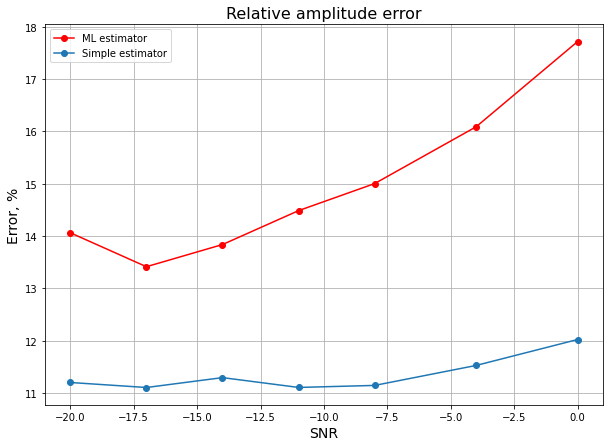

In [ ]:
plt.figure(figsize= (10,7))
plt.title("Relative amplitude error", fontsize = 16)
plt.xlabel("SNR", fontsize= 14)
plt.ylabel("Error, %", fontsize= 14)
plt.plot([-20,-17,-14,-11,-8,-4,0] ,(np.mean(dA, axis = 0)), 'o-',color ='r', label ='ML estimator')
plt.plot([-20,-17,-14,-11,-8,-4,0] ,(np.mean(dA_, axis = 0)), 'o-', label = 'Simple estimator')
plt.grid()
plt.legend();

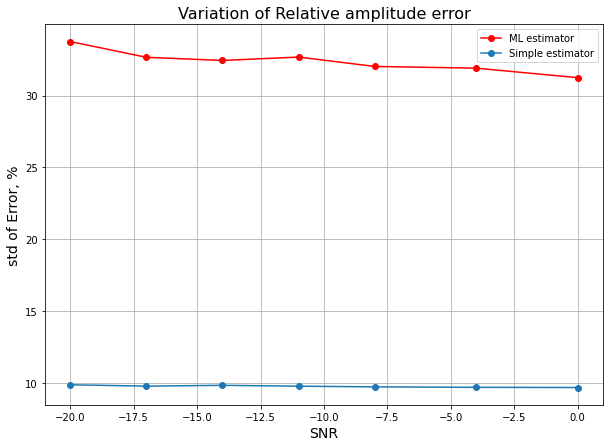

In [ ]:
plt.figure(figsize= (10,7))
plt.title("Variation of Relative amplitude error", fontsize = 16)
plt.xlabel("SNR", fontsize= 14)
plt.ylabel("std of Error, %", fontsize= 14)
plt.plot([-20,-17,-14,-11,-8,-4,0] ,(np.std(dA, axis = 0)), 'o-',color ='r', label ='ML estimator')
plt.plot([-20,-17,-14,-11,-8,-4,0] ,(np.std(dA_, axis = 0)), 'o-', label ='Simple estimator')
plt.grid()
plt.legend();

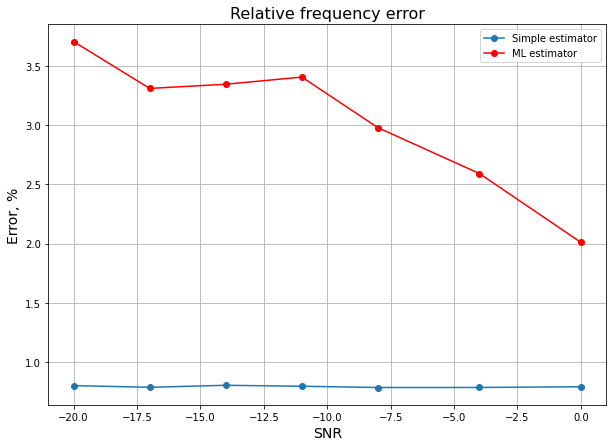

In [ ]:
plt.figure(figsize= (10,7))
plt.title("Relative frequency error", fontsize = 16)
plt.xlabel("SNR", fontsize= 14)
plt.ylabel("Error, %", fontsize= 14)
plt.plot([-20,-17,-14,-11,-8,-4,0] ,(np.mean(dw_, axis = 0)), 'o-', label = 'Simple estimator')
plt.plot([-20,-17,-14,-11,-8,-4,0] ,(np.mean(dw, axis = 0)), 'o-',color ='r', label ='ML estimator')
plt.grid()
plt.legend();

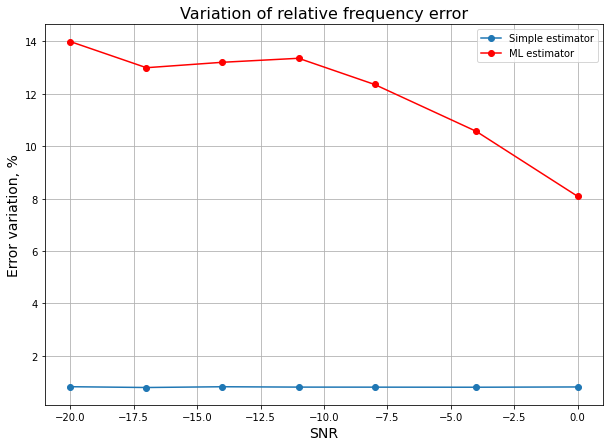

In [ ]:
plt.figure(figsize= (10,7))
plt.title("Variation of relative frequency error", fontsize = 16)
plt.xlabel("SNR", fontsize= 14)
plt.ylabel("Error variation, %", fontsize= 14)
plt.plot([-20,-17,-14,-11,-8,-4,0] ,(np.std(dw_, axis = 0)), 'o-', label ='Simple estimator')
plt.plot([-20,-17,-14,-11,-8,-4,0] ,(np.std(dw, axis = 0)), 'o-',color ='r', label ='ML estimator')
plt.grid()
plt.legend();

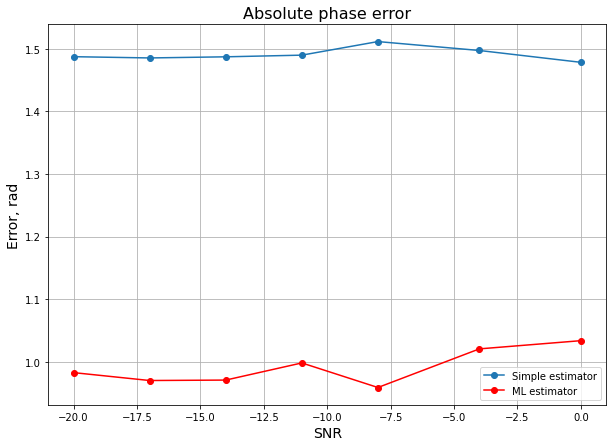

In [ ]:
plt.figure(figsize= (10,7))
plt.title("Absolute phase error", fontsize = 16)
plt.xlabel("SNR", fontsize= 14)
plt.ylabel("Error, rad", fontsize= 14)
plt.plot([-20,-17,-14,-11,-8,-4,0] ,(np.mean(dphi_, axis = 0)), 'o-', label = 'Simple estimator')
plt.plot([-20,-17,-14,-11,-8,-4,0] ,(np.mean(dphi, axis = 0)), 'o-',color ='r', label ='ML estimator')
plt.grid()
plt.legend();

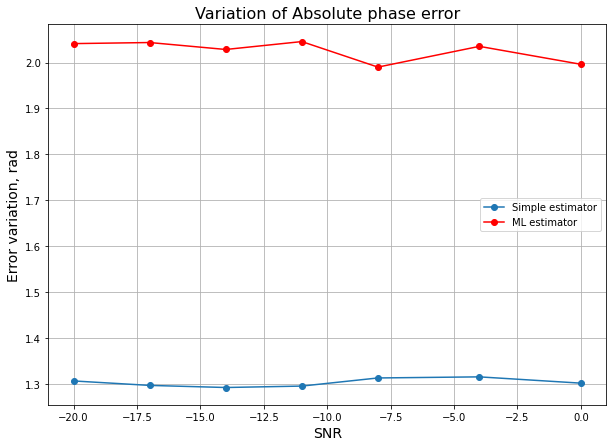

In [ ]:
plt.figure(figsize= (10,7))
plt.title("Variation of Absolute phase error", fontsize = 16)
plt.xlabel("SNR", fontsize= 14)
plt.ylabel("Error variation, rad", fontsize= 14)
plt.plot([-20,-17,-14,-11,-8,-4,0] ,(np.std(dphi_, axis = 0)), 'o-', label = 'Simple estimator')
plt.plot([-20,-17,-14,-11,-8,-4,0] ,(np.std(dphi, axis = 0)), 'o-',color ='r', label ='ML estimator')
plt.grid()
plt.legend();

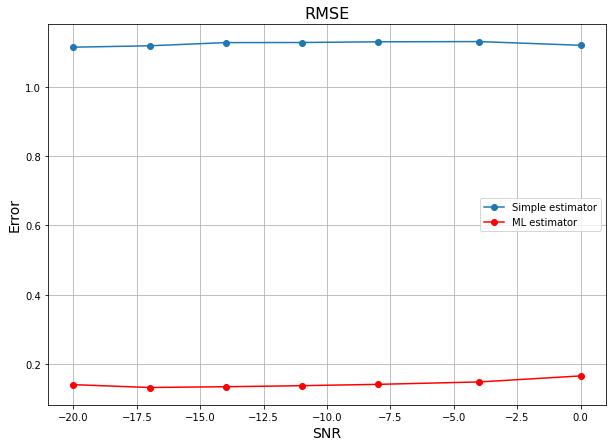

In [ ]:
plt.figure(figsize= (10,7))
plt.title("RMSE", fontsize = 16)
plt.xlabel("SNR", fontsize= 14)
plt.ylabel("Error", fontsize= 14)
plt.plot([-20,-17,-14,-11,-8,-4,0] ,(np.mean(drmse_, axis = 0)), 'o-', label='Simple estimator')
plt.plot([-20,-17,-14,-11,-8,-4,0] ,(np.mean(drmse, axis = 0)), 'o-', label = 'ML estimator', color ='r')
plt.grid()
plt.legend();

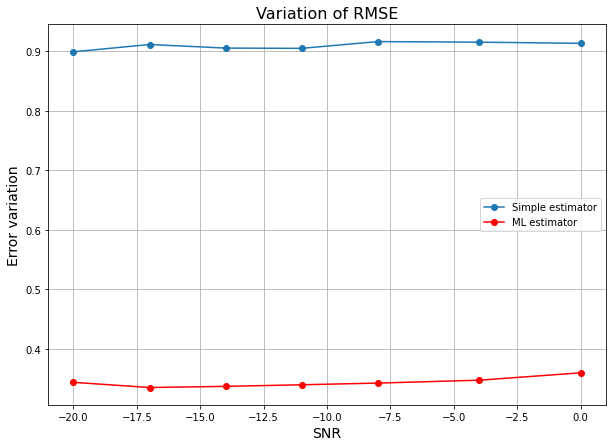

In [ ]:
plt.figure(figsize= (10,7))
plt.title("Variation of RMSE", fontsize = 16)
plt.xlabel("SNR", fontsize= 14)
plt.ylabel("Error variation", fontsize= 14)
plt.plot([-20,-17,-14,-11,-8,-4,0] ,(np.std(drmse_, axis = 0)), 'o-', label ='Simple estimator')
plt.plot([-20,-17,-14,-11,-8,-4,0] ,(np.std(drmse, axis = 0)), 'o-', label = 'ML estimator', color ='r')
plt.grid()
plt.legend();

Achived result a bit strange. Optimization process made estimated parameters worse, but from loss point of view, achived result is better than it was in case of Simple estimator. It seems to me, that this loss function is not good one, for this problem. So I think it would be better to use some loss function, that penalizes directly parameters of the signal.   